# Matrix properties
This notebook aims to look at general matrix properties and operations, such as the differences between eigendecomposition, singular value decomposition, PCA and fourier analysis of general matrices and covariance matrices.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import scipy
np.set_printoptions(precision=4, linewidth=100, suppress=True)

# Eigenvectors and Eigenvalues
If we have a linear operator $T: V \rightarrow V$ (T is a linear transformation from a vector space $V$ to itself), then applying $T$ to an eigenvector of $T$ (let us call it $\mathbf{v}$) only scales $\mathbf{v}$ and doesn't change its direction. I.e. 
$$
T(\mathbf{v}) = \lambda \mathbf{v}
$$

The mapping from $V\rightarrow V$ is the bit that enforces eigendecomposition to work only on square matrices.

In the simplest case, $T$ is a matrix operation $A$, so $A\mathbf{v} = \lambda \mathbf{v}$, but there are other linear operations like differentiation which has eigenvectors (or eigenfunctions). E.g. for differentiation $$\frac{d}{dx}e^{\lambda x} = \lambda e^{\lambda x}$$ So $e^{\lambda x}$ is an eigenfunction of differentiation.

One way to find the eigenvectors/eigenvalues is by solving the characteristic polynomial. I.e. 
$$
|A-\lambda I| = 0
$$

This is difficult to do for anything greater than a $2\times 2$ matrix as it will involve finding the roots of a high order polynomial.

Once we have found the eigenvectors and eigenvalues of $A$, then the eigendecomposition of A is:
$$
A = Q\Lambda Q^{-1}
$$

where 

$$
Q = \left[\mathbf{v}_1 | \mathbf{v}_2 | \cdots | \mathbf{v}_n \right]
$$

A nice way to interpret this is to consider $Q^{-1}$ as a change of basis matrix. Then we are equating $A$ and $\Lambda$ to the same linear transformation, just that we need to change the basis by applying $Q^{-1}$, then apply the transformation $\Lambda$, then change back to the original basis with $Q$.

## Eigendecomposition of Symmetric Matrices
When you take the eigendecomposition of a symmetric positive semidefinite matrix, you get an orthogonal basis of eigenvectors. I.e. $Q^{-1} = Q^{T}$. In general this is not the case and you have to also invert the resulting $Q$ matrix.

## Power Iteration method for finding the largest eigenvalue (and its vector)
A very simple and often used method to find the eigenvector with the largest eigenvalue is called the power iteration method. If you start with a random vector $\mathbf{b}_0$, we can apply the update step:
$$\mathbf{b}_{k+1} = \frac{A\mathbf{b}_k}{||A\mathbf{b}_k||}$$

Once we have the eigenvector, we can get its corresponding eigenvalue by using the Rayleigh quotient:
$$\lambda = \frac{\mathbf{b}_k^T A \mathbf{b}_k}{\mathbf{b}_k^T \mathbf{b}_k}$$

A modification of this - the Lanczos algorithm can be used to find several eigenvalues and eigenvectors of sparse matrices.

Let us try do this in numpy:

In [7]:
def rayleigh_quotient(A, b):
    return (b.T @ A @ b)/(b.T @ b)

def power_iteration(A, num_simulations):
    # Choose a random initial vector. We need to be careful as if the initial 
    # vector is orthogonal to the eigenvector, it will not converge.
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    λ_k = rayleigh_quotient(A, b_k)
    
    return b_k, λ_k

# Declare an array
A = np.array([[0.5, 0.5], [0.2, 0.8]])
b, λ = power_iteration(A, 20)
print('Result from power iteration method:')
print('Largest eigenvalue: {:.4f}\neigenvector: {}'.format(λ, b))

print('\nResults from numpy linalg package:')
print('All eigenvectors:')
w, v = np.linalg.eig(A)
for i in range(len(w)):
    print('{:.4f}: {}'.format(w[i], v[:,i]))

Result from power iteration method:
Largest eigenvalue: 1.0000
eigenvector: [0.7071 0.7071]

Results from numpy linalg package:
All eigenvectors:
0.3000: [-0.9285  0.3714]
1.0000: [-0.7071 -0.7071]


# Rayleigh Quotient
We introduced the Rayleigh quotient in the power method to find the eigenvalue of the corresponding eigenvector:
$$
R(M, x) = \frac{x^T M x}{x^T x} = \frac{\sum_{i=1}^n \lambda_i y_i^2}{\sum_{i=1}^n y_i^2}
$$

where $(\lambda _{i},v_{i})$ is the $i$th eigenpair after orthonormalization and $y_{i}=v_{i}^{*}x$ is the $i$th coordinate of x in the eigenbasis.

There are a couple of other neat properties about the Rayleigh Quotient:

- $R(M, x) \in [\lambda_{min}, \lambda_{max}]$ 
- If $M$ is a symmetric matrix (such as a covariance matrix), then the vectors which maximise/minimise the Rayleigh quotient are their corresponding eigenvectors

# Pseudo-Inverse
I've used this a lot but have not really realized. Consider a general matrix $A\in M(m,n;K)$ ($m$ rows, $n$ columns of values in the space $K$), the pseudo-inverse of A is defined as:
$$
A^+ \in M(n,m; K)
$$

If $A$ has more rows than columns (i.e. a very tall matrix with linearly independent columns), then $A^*A \in M(n,n;K)$ is invertible, and the psuedo-inverse is:
$$
A^+ = (A^*A)^{-1}A^*
$$

$$
A^+A = I
$$

If $A$ has more columns than rows (i.e. a fat matrix with linearly independent rows), then $AA^* \in M(m,m;K)$ is invertible and the pseudo-inverse is:

$$
A^+ = A^*(AA^*)^{-1}
$$

$$
AA^+ = I
$$

# SVD
This is a decomposition of an $m\times n$ matrix 
$$
M = U\Sigma V^{*}
$$

where $U \in \mathbb{C}^{m\times m}$, $V \in \mathbb{C}^{n \times n}$ and $\Sigma \in \mathbb{C}^{m\times n}$. The diagonal entries $\sigma_i$ of $\Sigma$ are the singular values of $M$. The left singular values of $M$ ($U$) are a set of orthonormal eigenvectors of $MM^*$. The right singular vectors of $M$ ($V$) are a set of orthonormal eigenvectors of $M^*M$. The non-zero singular values of $M$ are the square roots of the non-zero eigenvalues of $M^*M$ and $MM^*$.

A non-negative real number, $\sigma$ is a singular value for $M$ iff there exist unit length vectors $u\in \mathbb{C}^{m\times m}$ and $v \in \mathbb{C}^{n \times n}$ where $Mv = \sigma u$ and $M^*u = \sigma v$.

Also note that
$$
M^*M = V\Sigma^*U^*U\Sigma V^* = V\Sigma^*\Sigma V^*
$$

$$
MM^*= U\Sigma V* V\Sigma^* U^* = U\Sigma\Sigma^* U^*
$$

So that the nonzero elements of $\Sigma$ are the square roots of the non-zero eigenvalues of $M^*M$ or $MM*$.

Note that if we have the SVD of a matrix, it is easier to calculate its psuedo-inverse, as 

$$
M^+ = V\Sigma^+U^*
$$

And $\Sigma^+$ is simply formed by replacing every non-zero diagonal by its reciprocal and transposing the resulting matrix. This is used a lot in linear least squares problems.

# Tikhonov Regularization
Tikhonov regularization is the general term for the regularization we normally use, except that it allows for more complex terms. I.e. instead of minimizing
$$
||Ax-b||_2^2
$$

we minimize
$$
||Ax-b||^2_2 + ||\Gamma x||^2_2
$$

for some suitably chosen Tikhonov matrix $\Gamma$. In many cases $\Gamma = \alpha I$, in which case this collapses to $L2$ regularization, but it could be a more special matrix too.

## Regularized Least Squares
If we wanted to solve unregularized least squares, then for
$$A = U\Sigma V^T \\
\hat{x} = V\Sigma^+U^Tb \\
$$

And with regularization:

$$
\hat{x}  = VDU^T b \\
\text{with} \\
D_{ii} = \frac{\sigma_i}{\sigma_i^2 + \alpha^2}
$$

# Frobenius Norm and Singular Values
There is a special case worth mentioning for the frobenius norm of a matrix:

$$
||A||_2^2 = \sum_{i,j} A_{i,j}^2 = \sum_i \sigma_i^2
$$

Where $\sigma_i$ is the $i$th singular value of $A$.

# Positive Semi-Definite Matrices and Diagonal Dominance
If a matrix is diagonally dominant, i.e.
$$
h_{i,i} \geq \sum_{j \neq i} |h_{ij}|
$$

and $h_{i,i} \geq 0$, then we have a PSD matrix (this property is sufficient but not necessary). It is often why we sometimes add a small identity matrix to a covariance matrix to make sure we are satisfying its PSD conditions.

# PCA
As stated before, if a matrix is symmetric then the eigenvalues of it are orthogonal and $Q^{-1}=Q^{T}$. PCA finds the eigenvectors of the covariance matrix $C = (X-\mu)^T (X-\mu)$, and sorts them so that the eigenvalues are given in decreasing order. It is also equivalent to finding the singular values of $X-\mu$.

In [19]:
from sklearn.decomposition import PCA

print('-'*50)
print('PCA direct method')
print('-'*50)
X = np.random.rand(5,5)
pca = PCA()
y = pca.fit(X)
v1 = y.components_.T
print(v1)

print('\n'+ '-'*50)
print('Eigendecomposition of sample covariance matrix')
print('-'*50)
u = np.mean(X, axis=0)
# Sort by eigenvalues
w, v = np.linalg.eigh((X-u).T @ (X-u))
k = np.argsort(w)[::-1]
print('Eigenvalues in decreasing size:')
print(w[k])
print('\nCorresponding eigenvectors')
print(v[:,k])

print('\n'+ '-'*50)
print('SVD of sample matrix')
print('-'*50)
u, s, v = np.linalg.svd(X-u)
print('Square of the singular values')
print(s**2)
print('\nRight singular vectors:')
print(v)

--------------------------------------------------
PCA direct method
--------------------------------------------------
[[ 0.1739 -0.4942  0.8359 -0.1532  0.0565]
 [-0.5933  0.1449  0.1428 -0.0759  0.7752]
 [-0.2748 -0.4962 -0.0846  0.8189 -0.0219]
 [ 0.3267  0.6463  0.407   0.5461  0.1077]
 [ 0.6599 -0.2661 -0.3287  0.0429  0.6195]]

--------------------------------------------------
Eigendecomposition of sample covariance matrix
--------------------------------------------------
Eigenvalues in decreasing size:
[ 9.1117e-01  5.3306e-01  1.0585e-01  2.5098e-03 -3.9139e-17]

Corresponding eigenvectors
[[-0.1739  0.4942  0.8359  0.1532  0.0565]
 [ 0.5933 -0.1449  0.1428  0.0759  0.7752]
 [ 0.2748  0.4962 -0.0846 -0.8189 -0.0219]
 [-0.3267 -0.6463  0.407  -0.5461  0.1077]
 [-0.6599  0.2661 -0.3287 -0.0429  0.6195]]

--------------------------------------------------
SVD of sample matrix
--------------------------------------------------
Square of the singular values
[0.9112 0.5331 0.1058 

# Fourier Bases and PCA

In Olshausen and Field 97 - there is a comment that reads:

    Because the image statistics are roughly stationary, the eigenvectors of the covariance matrix will essentially be equivalent to the Fourier bases.
    
This is something that is not entirely obvious to me, but empirically proveable. Let us take in a sample image and find the principle components of all $10\times 10$ blocks of it.

<IPython.core.display.Javascript object>


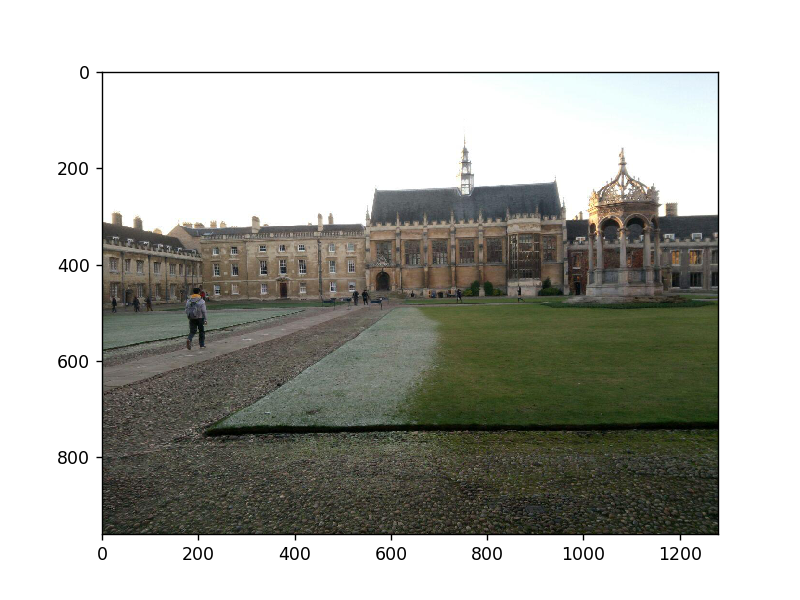

In [4]:
from PIL import Image
import plotters # a package of mine from https://github.com/fbcotter/plotters
from sklearn.decomposition import PCA
im = np.array(Image.open('trinity.jpg'))
plt.figure()
plt.imshow(im)

<IPython.core.display.Javascript object>


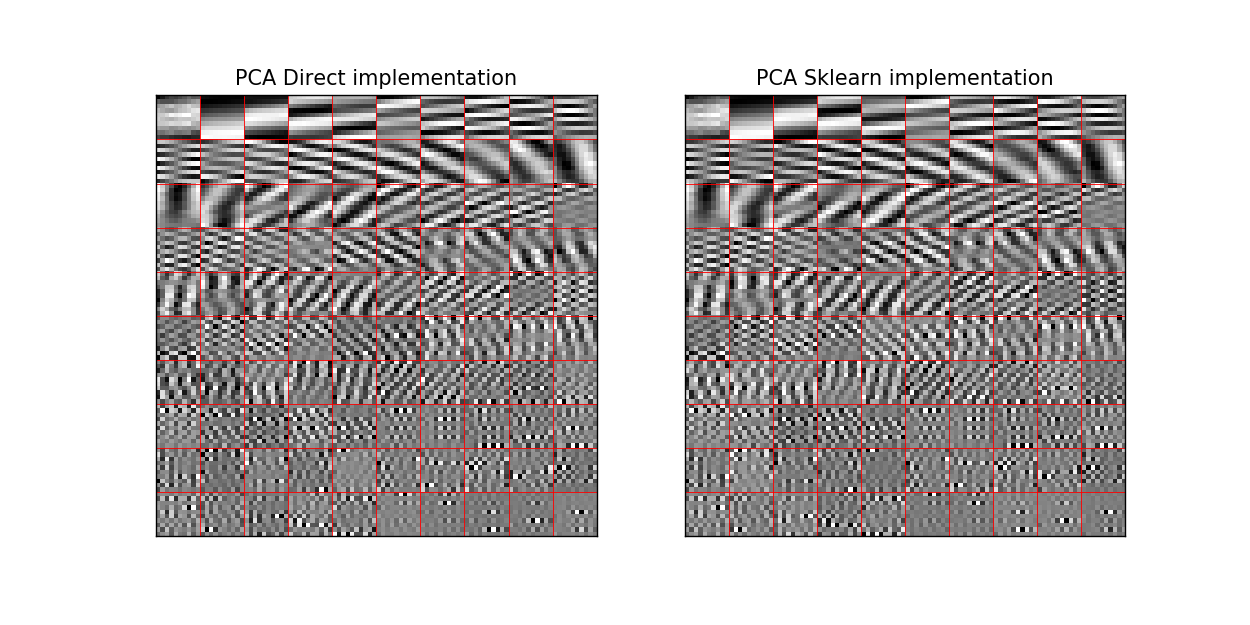

In [5]:
X = np.reshape(np.transpose(im, (2,0,1)), (-1,10*10))
u = np.mean(X, axis=0)
# Calculate all the covariance matrices
C = 1/X.shape[0] * (X-u).T @ (X-u)

# Get the eigenvectors of C
w, v = np.linalg.eigh(C)
k = np.argsort(w)[::-1]

# Plot the result
z = v.reshape((10,10,100))
fig, ax = plt.subplots(1,2, figsize=(10,5))
plotters.plot_activations(z[:,:,k], cols=10, ax=ax[0])
ax[0].set_title('PCA Direct implementation');

# Compare to Sklearn PCA
pca = PCA(n_components=100)
pca.fit(X)
Z = pca.components_.reshape((100,10,10))
plotters.plot_activations(Z.transpose((1,2,0)), cols=10, ax=ax[1]);
ax[1].set_title('PCA Sklearn implementation');

<IPython.core.display.Javascript object>


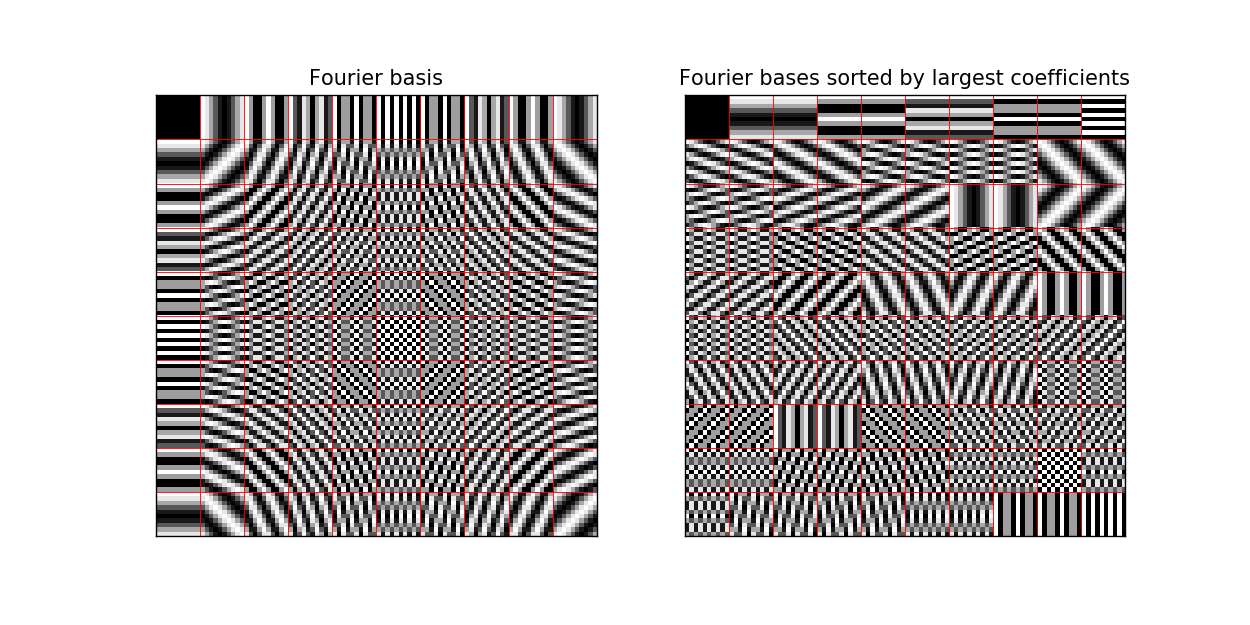

In [6]:
# Calculate the Fourier basis
W = np.exp(-1j*2*np.pi*np.outer(np.arange(0,10), np.arange(0,10))/10)
W2 = W.ravel()
Z = np.outer(W2, W2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
plotters.plot_activations(Z.reshape((10,100,10)).transpose((0,2,1)).real, cols=10, ax=ax[0]);
ax[0].set_title('Fourier basis');

# Calculate the fourier coefficients for each 10x10 block
W = np.fft.fft2((X-u).reshape(-1, 10, 10))
# Get the mean energy of each
e = np.mean(np.abs(W), axis=0)[:10,:10].ravel()
# Sort by descending power
k = np.argsort(e)[::-1]

plotters.plot_activations(Z.reshape((10,100,10)).transpose((0,2,1))[:,:,k].real, cols=10, ax=ax[1]);
ax[1].set_title('Fourier bases sorted by largest coefficients');

So I can see that the second image here is similar to the two above, but I wouldn't say exactly the same. Nonetheless it was an interesting experiment. 

Why are they similar? 

The result comes from the fact that for stationary signals, the Covariance matrix becomes Toeplitz, and supposedly the eigenvectors of toeplitz matrices are complex exponentials. I couldn't find a proof for this though.